In [3]:
import os
import math

from einops import rearrange
from shapely import Polygon, MultiPolygon
from matplotlib import colormaps
from rasterio.features import shapes
import numpy as np
import pytesseract
import rasterio
import skimage
import matplotlib.pyplot as plt
import seaborn as sns

## V1

In [12]:
def to_float(x):
    x = x.astype(float)
    x /= 255
    return x

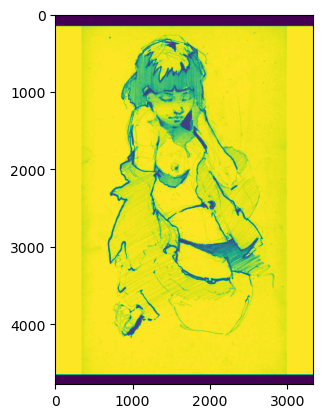

In [13]:
values = skimage.io.imread('/Users/erikstorrs/Downloads/mann_1/values.png')
values = to_float(values)
values = skimage.color.rgb2gray(values[..., :-1])
plt.imshow(values)

In [14]:
pytesseract.image_to_string(x)

'<matplotlib. image.AxesImage at 0x28085cb90>\n\nTT\n1000 4\n2000 4\n3000 4\n\n4000 4\n\n0 1000 2000 3000\n'

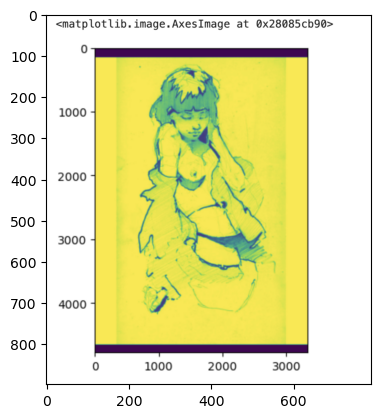

In [15]:
x = skimage.io.imread('/Users/erikstorrs/Desktop/a.png')
plt.imshow(x)

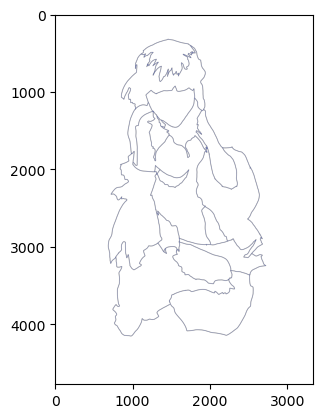

In [16]:
polygon_img = skimage.io.imread('/Users/erikstorrs/Downloads/mann_1/polygons.png')
polygon_img = to_float(polygon_img)
plt.imshow(polygon_img)

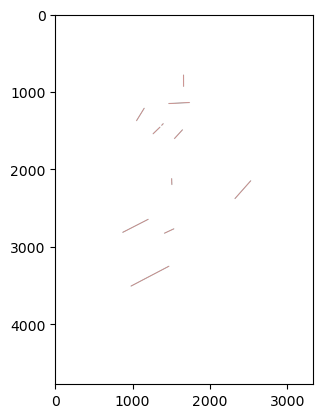

In [17]:
direction_img = skimage.io.imread('/Users/erikstorrs/Downloads/mann_1/directions.png')
direction_img = to_float(direction_img)
plt.imshow(direction_img)

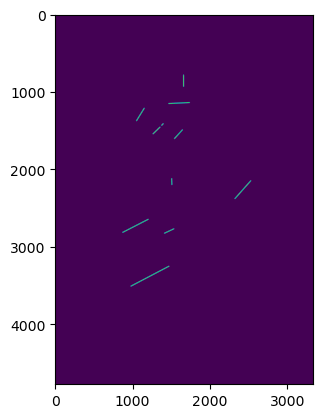

In [18]:
direction_outlines = direction_img.mean(-1) > 0
plt.imshow(direction_outlines)

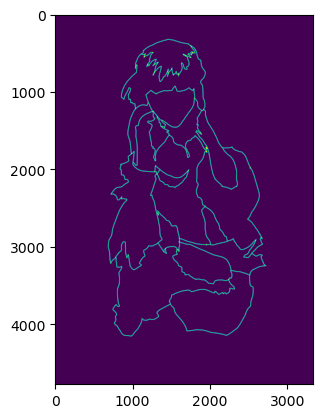

In [19]:
polygon_outlines = polygon_img.mean(-1) > 0
plt.imshow(polygon_outlines)

In [20]:
meshes = np.stack(np.meshgrid(np.arange(polygon_outlines.shape[0]), np.arange(polygon_outlines.shape[1]), indexing='ij'))
pts = rearrange(meshes, 'c h w -> (h w) c')
pts = pts[np.random.permutation(pts.shape[0])]
pts = pts[np.asarray([not polygon_outlines[r, c] for r, c in pts])]

labeled = np.zeros_like(polygon_outlines, dtype=int)
masks = []
count = 0
while True:
    count += 1
    mask = None
    for pt in pts:
        mask = skimage.segmentation.flood(polygon_outlines, tuple(pt))
        masks.append(mask)
        labeled[mask] = count
        break

    keep = ~mask[pts[:, 0], pts[:, 1]]
    pts = pts[keep]

    if not len(pts):
        break

labeled = skimage.segmentation.expand_labels(labeled, 100)

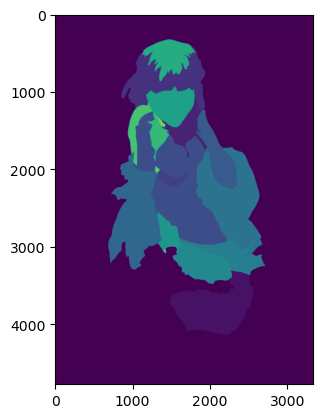

In [21]:
plt.imshow(labeled)

In [23]:
label_to_data = {}
props = skimage.measure.regionprops(labeled)
for prop in props:
    l = prop.label
    mask = labeled == l

    direction_mask = direction_outlines.copy()
    direction_mask[~mask] = 0
    if direction_mask.mean():
        pts = np.argwhere(skimage.morphology.skeletonize(direction_mask)).astype(float)
        v = pts[-1] - pts[0]
        v /= np.linalg.norm(v)

        data = {
            'direction': v,
            'fill_types': ['line'],
            'centroid': np.asarray(prop.centroid).astype(int),
            'prop': prop
        }
    else:
        data = {
            'fill_types': ['noise'],
            'centroid': np.asarray(prop.centroid).astype(int),
            'prop': prop
        }

    label_to_data[l] = data

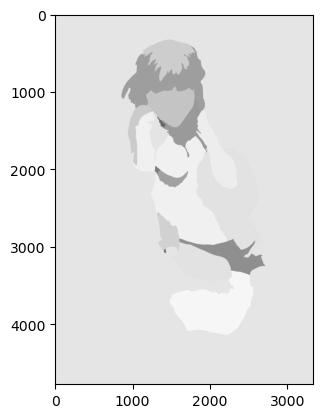

In [24]:
simple = np.ones((labeled.shape[0], labeled.shape[1], 3), dtype=float)

for l in np.unique(labeled):
    if l:
        mask = labeled==l
        avg = values[mask].mean()
        simple[mask] = [avg] * 3
        label_to_data[l]['value'] = avg
plt.imshow(simple)

In [25]:
def get_line_coords(ep1, ep2, size=None):
    ep1, ep2 = ep1.astype(int), ep2.astype(int)
    rr, cc = skimage.draw.line(ep1[0], ep1[1], ep2[0], ep2[1])

    if size is not None:
        exclude = rr < 0
        exclude |= rr >= size[0]
        exclude |= cc < 0
        exclude |= cc >= size[1] 
        rr, cc = rr[~exclude], cc[~exclude]

    return rr, cc

def add_line(x, thickness, pt1, pt2, v, size=None, label_value=True):
    for i in range(thickness // 2):
        ep1, ep2 = pt1 + (v * i), pt2 + (v * i)
        rr, cc = get_line_coords(ep1, ep2, size=size)
        x[rr, cc] = label_value
    
        ep1, ep2 = pt1 - (v * i), pt2 - (v * i)
        rr, cc = get_line_coords(ep1, ep2, size=size)
        x[rr, cc] = label_value

def add_spaced_lines(x, v, mag, centroid, thickness=20, offset=30):
    current = int(x.max() + 1)

    v1 = v[[1, 0]] * [1, -1]
    v2 = v[[1, 0]] * [-1, 1]
    
    v1_offset = v1 * mag
    v2_offset = v2 * mag

    offsets = np.concat((np.linspace(-mag, 0, int(mag / offset)), np.linspace(0, mag, int(mag / offset))))
    offset_vectors = np.repeat(np.expand_dims(v, 0), len(offsets), 0)
    offset_vectors = (offset_vectors.T * offsets).T
    
    for ov in offset_vectors:
        e1 = v1_offset + centroid + ov
        e2 = v2_offset + centroid + ov
        
        add_line(x, thickness, e1, e2, v, size=x.shape, label_value=current)
        current += 1

In [26]:
def adjust_to_value(value, labeled_objs, region_mask, jitter=.1):
    labels = np.unique(labeled_objs)
    new = np.zeros_like(labeled_objs)

    for l in labels:
        if l:
            m = labeled_objs == l
            pts = np.argwhere(m)
            
            j = np.random.uniform(-jitter, jitter)
            total = (value + j) * np.count_nonzero(region_mask)
            target = total / np.count_nonzero(labeled_objs>0)
            n = int(target * len(pts))
            idxs = np.random.permutation(np.arange(pts.shape[0]))[:n]
            pts = pts[idxs]
            new[pts[:, 0], pts[:, 1]] = l
    return new
            
    

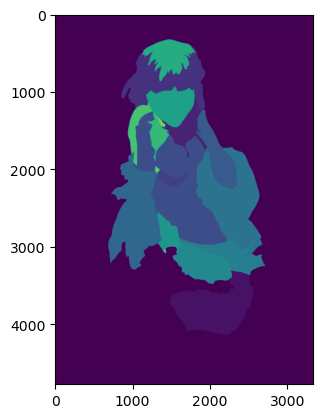

In [27]:
plt.imshow(labeled)

1
3
4
5
8
9
12
13
15
16
18


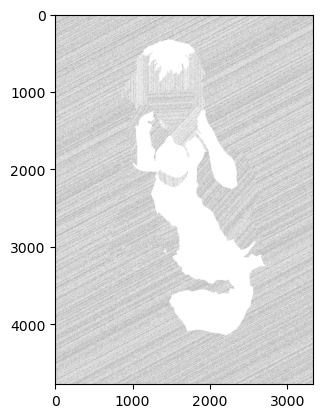

In [28]:
thickness = 8
offset = 12

canvas = np.ones_like(simple)

for l, data in label_to_data.items():
    if 'line' in data['fill_types']:
        print(l)
        mask = labeled == l
        prop = data['prop']
        centroid = data['centroid']
    
        v = data['direction'].copy()
        
        v = v[[1, 0]] * [1, -1]
    
        r1, c1, r2, c2 = prop.bbox
        mag = math.dist((r1, c1), (r2, c2))
    
        blank = np.zeros_like(direction_outlines, dtype=int)
        add_spaced_lines(blank, v, mag, centroid, thickness=thickness, offset=offset)
        
        blank[~mask] = 0
        
        new = adjust_to_value(data['value'] * .2, blank, mask, jitter=.05)

        canvas[new > 0] = [0, 0, 0]
        
plt.imshow(canvas)

1 0.8998003269613055
3 0.607359842715543
4 0.6227077024567164
5 0.6344990236254422
8 0.9016955845004573
9 0.8871025479260645
12 0.8200267961129534
13 0.7708707639348547
15 0.8969471609100338
16 0.7984184338695361
18 0.40585303149431684


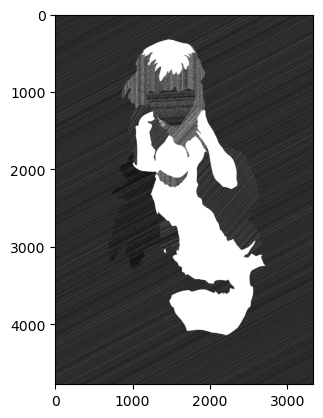

In [36]:
thickness = 30
offset = 20

canvas = np.ones_like(simple)

for l, data in label_to_data.items():
    if 'line' in data['fill_types']:
        print(l, data['value'])
        mask = labeled == l
        prop = data['prop']
        centroid = data['centroid']
    
        v = data['direction'].copy()
        
        v = v[[1, 0]] * [1, -1]
    
        r1, c1, r2, c2 = prop.bbox
        mag = math.dist((r1, c1), (r2, c2))
    
        blank = np.zeros_like(direction_outlines, dtype=int)
        add_spaced_lines(blank, v, mag, centroid, thickness=thickness, offset=offset)
        
        blank[~mask] = 0
        
        new = adjust_to_value(data['value'], blank, mask, jitter=.1)

        canvas[new > 0] = [0, 0, 0]
        
plt.imshow(canvas)

In [37]:
x = canvas.copy()
x *= 255
x = x.astype(np.uint8)
skimage.io.imsave('~/Downloads/test2.png', x)

In [40]:
import tifffile
tifffile.imwrite('/Users/erikstorrs/Downloads/test2.tif', x)

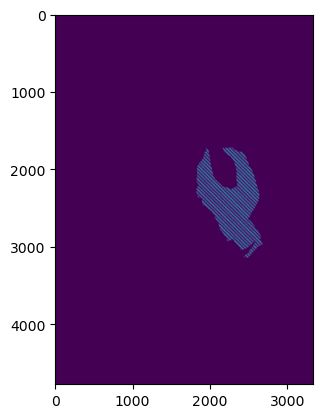

In [259]:
new = adjust_to_value(.2, blank, mask, jitter=.05)
plt.imshow(new>0)

In [122]:
def rotate_vector(a):
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    
    return np.dot(R, a)

(np.float64(-10.488658896059954),
 np.float64(1.2210070007647598),
 np.float64(-6.5068699),
 np.float64(1.06937416))

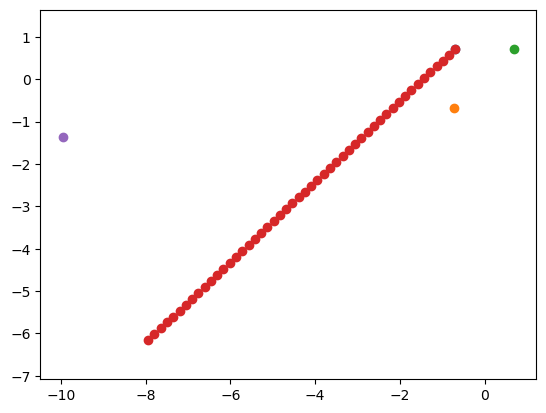

In [121]:
plt.scatter(v[1], v[0])
plt.scatter(v1[1], v1[0])
plt.scatter(v2[1], v2[0])
plt.scatter(new[:, 1], new[:, 0])
plt.scatter(A[1], A[0])
plt.axis('equal')

In [81]:
perp = -(1 / slope)
perp

-0.5

In [79]:
skimage.draw.line(

0.5

In [ ]:
def generate_coords(m, mag_range=(.1, .2), n=10):
    m = -m # make negative bc y is flipped for images
    slope = np.asarray([1, m])
    slope /= np.linalg.norm(slope)
    
    perp1 = np.asarray([slope[1], -slope[0]])
    perp1 /= np.linalg.norm(perp1)
    perp2 = np.asarray([-slope[1], slope[0]])
    perp2 /= np.linalg.norm(perp2)

    xs = np.linspace(0, slope[0], n)
    ys = xs * m

    heads, tails = [], []
    for x, y in zip(xs, ys):
        v1 = perp1 * np.random.uniform(mag_range[0], mag_range[1])
        v2 = perp2 * np.random.uniform(mag_range[0], mag_range[1])
    
        offset = np.asarray([x, y])
        v1 += offset
        v2 += offset
        
        heads.append(v1)
        tails.append(v2)
    
    heads = np.stack(heads)
    tails = np.flip(np.stack(tails), 0)
    
    coords = np.concat((heads, tails))
    return coords

def get_stamp(coords, n=8, scale=10.):
    idxs = np.random.choice(np.arange(coords.shape[0]), size=n, replace=False)
    idxs = np.sort(idxs)
    selected = coords[idxs]

    scaled = selected * scale
    scaled -= scaled.min(0)
    scaled = scaled.astype(int)
    scaled = scaled[:, [1, 0]]
    size = scaled.max(0)
    
    return skimage.draw.polygon2mask(size, scaled)

def stamp_from_slope(m, mag_range=(.1, .2), n=10, scale=50.):
    coords = generate_coords(float(m), mag_range=mag_range, n=n)
    stamp = get_stamp(coords, scale=scale)
    return stamp

In [ ]:
def apply_mark(img, color, slope, pt, mag_range=(.1, .2), scale=50.):
    y, x = pt
    stamp = stamp_from_slope(slope, mag_range=mag_range, scale=scale)
    h, w = stamp.shape
    
    r_minus =  y - h // 2
    c_minus = x - w // 2
    
    if r_minus <= 0:
        r1 = 0
        r2 = h + r1 - np.abs(r_minus)
        stamp_r1 = np.abs(r_minus)
        stamp_r2 = stamp_r1 + (r2 - r1)
    else:
        r1 = r_minus
        r2 = min(img.shape[0], r1 + h)
        stamp_r1 = 0
        stamp_r2 = stamp_r1 + (r2 - r1)
    
    if c_minus <= 0:
        c1 = 0
        c2 = w + c1 - np.abs(c_minus)
        stamp_c1 = np.abs(c_minus)
        stamp_c2 =  stamp_c1 + (c2 - c1)
    else:
        c1 = c_minus
        c2 = min(img.shape[1], c1 + w)
        stamp_c1 = 0
        stamp_c2 = stamp_c1 + (c2 - c1)
    
    stamp_mask = stamp[stamp_r1:stamp_r2, stamp_c1:stamp_c2]
    
    img[r1:r2, c1:c2][stamp_mask] = color

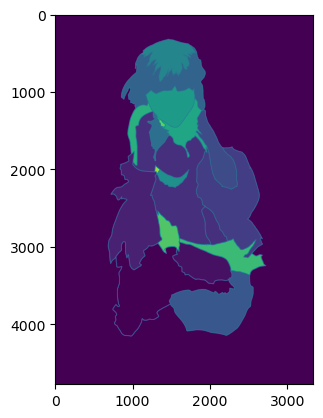

In [26]:
labeled = skimage.segmentation.expand_labels(labeled, 100)
plt.imshow(labeled)

In [13]:
def shapely_from_mask(mask):
    objs = shapes(mask.astype(np.int16), mask=mask > 0)
    p = next(iter(objs))
    coordinates = p[0]['coordinates']

    if len(coordinates) == 1:
        poly = Polygon(coordinates[0])
    else:
        poly = Polygon(shell=coordinates[0], holes=coordinates[1:])

    return poly

In [14]:
meshes = np.stack(np.meshgrid(np.arange(polygon_outlines.shape[0]), np.arange(polygon_outlines.shape[1]), indexing='ij'))
pts = rearrange(meshes, 'c h w -> (h w) c')
pts = pts[np.random.permutation(pts.shape[0])]

polys = []
masks = []
while True:
    mask = None
    for pt in pts:
        mask = skimage.segmentation.flood(polygon_outlines, tuple(pt))
        poly = shapely_from_mask(np.flip(mask, 0))
        polys.append(poly)
        masks.append(mask)
        break

    keep = ~mask[pts[:, 0], pts[:, 1]]
    pts = pts[keep]
    print(pts.shape)

    if not len(pts):
        break
        

(15568335, 2)
(4180638, 2)
(3902335, 2)
(3059628, 2)
(2824495, 2)
(2255679, 2)
(2052122, 2)
(1455217, 2)
(942856, 2)
(821151, 2)
(648650, 2)
(585851, 2)
(379917, 2)
(306203, 2)
(124147, 2)
(44389, 2)
(6559, 2)
(3902, 2)
(481, 2)
(3, 2)
(2, 2)
(1, 2)
(0, 2)


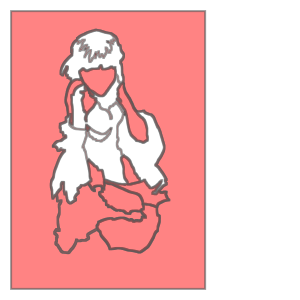

In [15]:
scene = MultiPolygon(polys)
scene

In [16]:
p = polys[0]

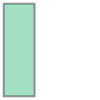

In [17]:
p

In [20]:
for x, y in p.boundary.coords:
    print(x, y)

1452.0 4032.0
1452.0 4035.0
1453.0 4035.0
1453.0 4032.0
1452.0 4032.0


## V2

In [179]:
def to_float(x):
    x = x.astype(float)
    x /= 255
    return x

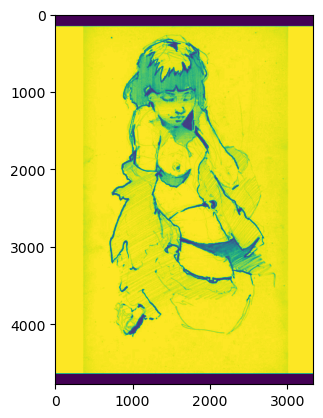

In [180]:
values = skimage.io.imread('/Users/erikstorrs/Downloads/mann_v3/values.png')
values = to_float(values)
values = skimage.color.rgb2gray(values[..., :-1])
plt.imshow(values)

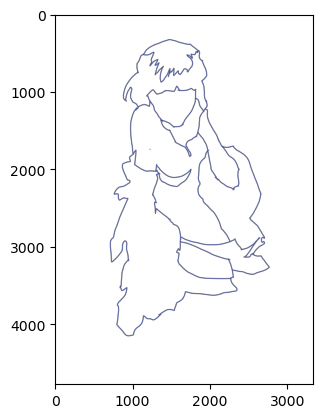

In [181]:
polygon_img = skimage.io.imread('/Users/erikstorrs/Downloads/mann_v3/polygons.png')
polygon_img = to_float(polygon_img)
plt.imshow(polygon_img)

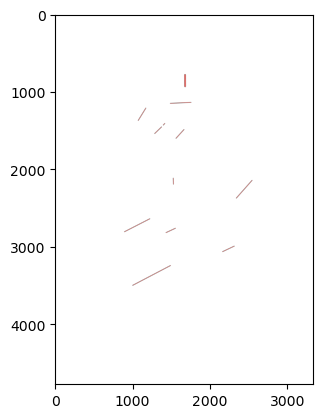

In [182]:
direction_img = skimage.io.imread('/Users/erikstorrs/Downloads/mann_v3/directions.png')
direction_img = to_float(direction_img)
plt.imshow(direction_img)

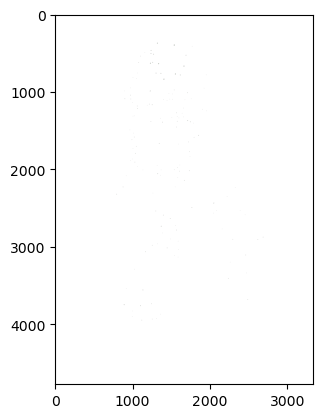

In [183]:
pt_img = skimage.io.imread('/Users/erikstorrs/Downloads/mann_v3/line_points.png')
pt_img = to_float(pt_img)
plt.imshow(pt_img)

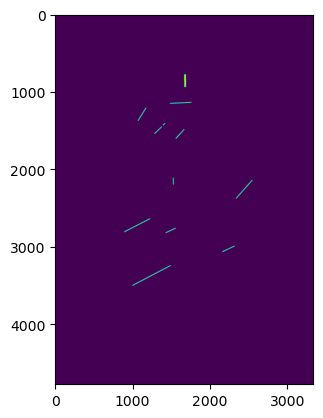

In [184]:
direction_outlines = direction_img.mean(-1) > 0
plt.imshow(direction_outlines)

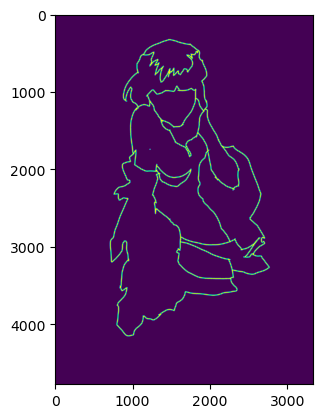

In [185]:
polygon_outlines = polygon_img.mean(-1) > 0
plt.imshow(polygon_outlines)

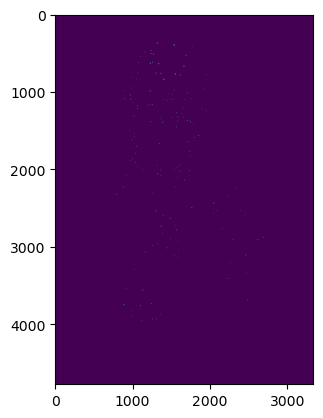

In [186]:
pt_outlines = pt_img.mean(-1) > 0
plt.imshow(pt_outlines)

In [187]:
meshes = np.stack(np.meshgrid(np.arange(polygon_outlines.shape[0]), np.arange(polygon_outlines.shape[1]), indexing='ij'))
pts = rearrange(meshes, 'c h w -> (h w) c')
pts = pts[np.random.permutation(pts.shape[0])]
pts = pts[np.asarray([not polygon_outlines[r, c] for r, c in pts])]

labeled = np.zeros_like(polygon_outlines, dtype=int)
masks = []
count = 0
while True:
    count += 1
    mask = None
    for pt in pts:
        mask = skimage.segmentation.flood(polygon_outlines, tuple(pt))
        masks.append(mask)
        labeled[mask] = count
        break

    keep = ~mask[pts[:, 0], pts[:, 1]]
    pts = pts[keep]

    if not len(pts):
        break

labeled = skimage.segmentation.expand_labels(labeled, 100)

In [188]:
label_to_data = {}
props = skimage.measure.regionprops(labeled)
for prop in props:
    l = prop.label
    mask = labeled == l

    direction_mask = direction_outlines.copy()
    direction_mask[~mask] = 0
    if direction_mask.mean():
        pts = np.argwhere(skimage.morphology.skeletonize(direction_mask)).astype(float)
        v = pts[-1] - pts[0]
        v /= np.linalg.norm(v)

        data = {
            'direction': v,
            'fill_types': ['line'],
            'centroid': np.asarray(prop.centroid).astype(int),
            'prop': prop
        }
    else:
        data = {
            'fill_types': ['noise'],
            'centroid': np.asarray(prop.centroid).astype(int),
            'prop': prop
        }

    label_to_data[l] = data

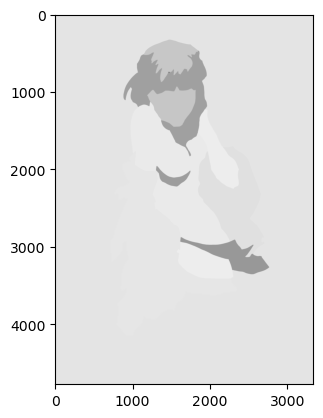

In [189]:
simple = np.ones((labeled.shape[0], labeled.shape[1], 3), dtype=float)

for l in np.unique(labeled):
    if l:
        mask = labeled==l
        avg = values[mask].mean()
        simple[mask] = [avg] * 3
        label_to_data[l]['value'] = avg
plt.imshow(simple)

In [107]:
labeled_pts = skimage.morphology.label(pt_outlines)
props = skimage.measure.regionprops(labeled_pts)
len(props)

145

In [127]:
tol = .05
line_img = np.zeros_like(simple)
labeled_lines = np.zeros_like(labeled_pts)
for prop in props:
    r, c = prop.coords[0]
    val = values[r, c]

    min_val = val - tol
    max_val = val + tol
    val_mask = ((values >= min_val) & (values <= max_val))

    mask = skimage.morphology.flood(values, (r, c), tolerance=tol)

    # for i in range(4):
    #     mask = skimage.morphology.binary_erosion(mask)

    
    labeled_lines[mask] = prop.label

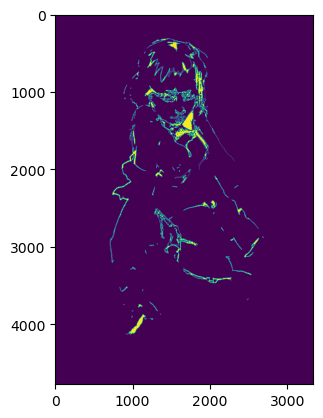

In [128]:
plt.imshow(labeled_lines>0)

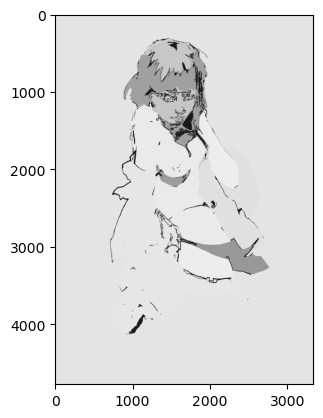

In [129]:
x = simple.copy()
x[labeled_lines > 0] = .1
plt.imshow(x)

In [111]:
x.shape

(4776, 3336, 3)

1 0.8804330518530187


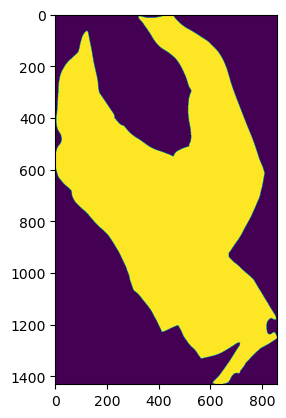

2 0.8976291758972205


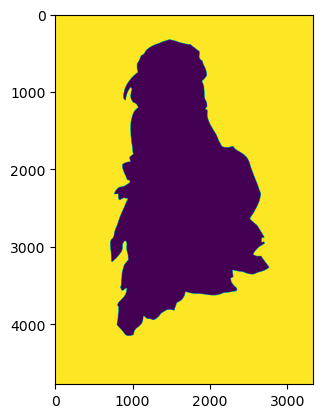

3 0.7804104178230944


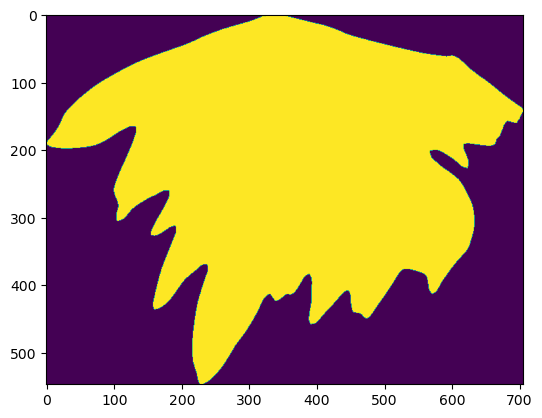

4 0.9025189591492967


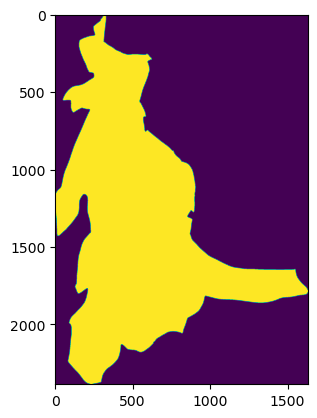

5 0.7771103060922295


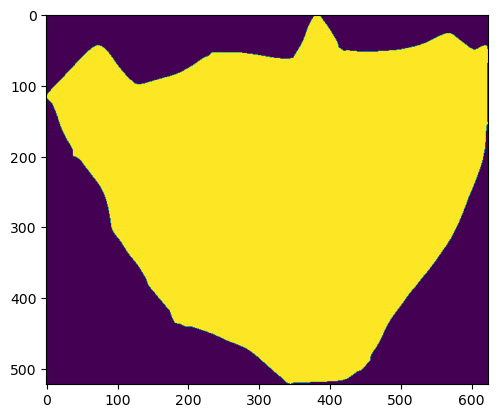

6 0.9311510083973281


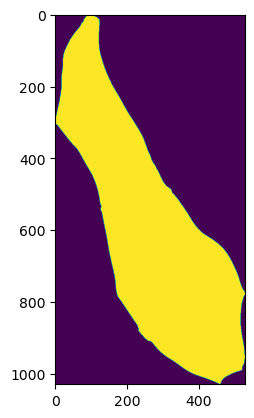

7 0.630311445767488


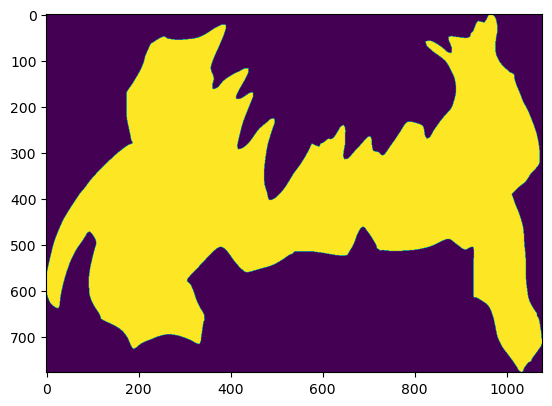

8 0.9199866773507372


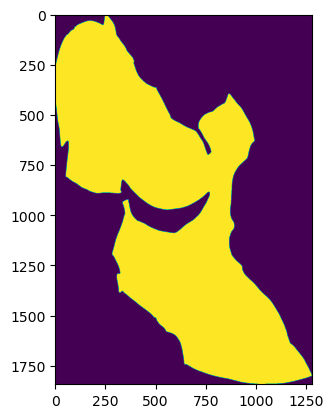

9 0.5978574449221227


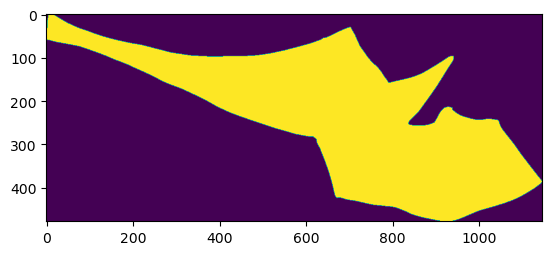

10 0.6285993113980657


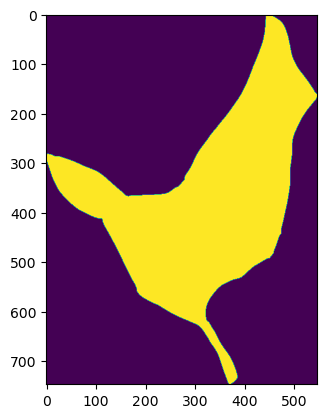

11 0.9310226498686294


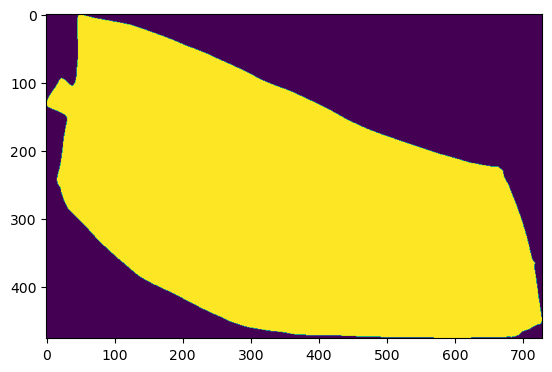

12 0.6166747454130321


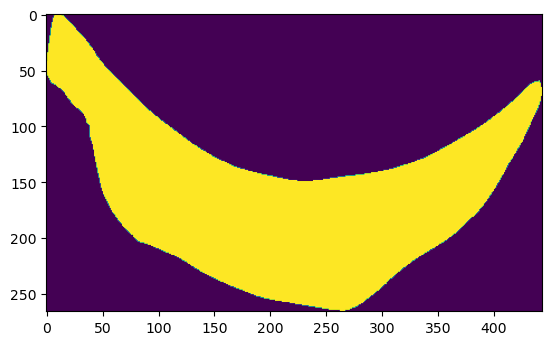

13 0.3953032186065917


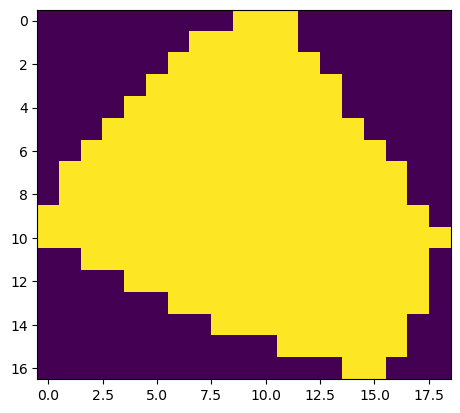

In [246]:
for label, data in label_to_data.items():
    print(label, data['value'])
    plt.imshow(data['prop']['image'])
    plt.show()

In [257]:
label_to_data[4]['value'] = .75
label_to_data[1]['value'] = .75
label_to_data[2]['value'] = 1.

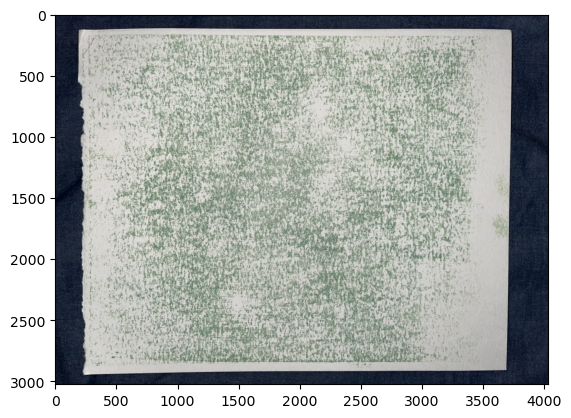

In [197]:
img = skimage.io.imread('/Users/erikstorrs/Downloads/IMG_0803.jpg')
img = to_float(img)
plt.imshow(img)

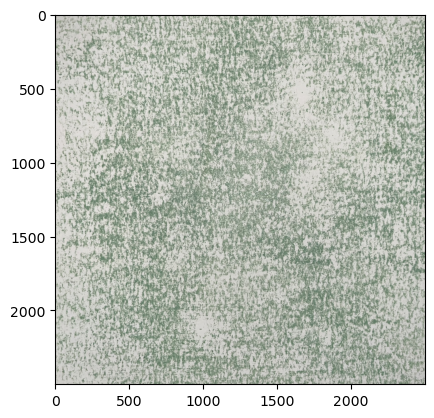

In [198]:
r1, r2, c1, c2 = 250, 2750, 500, 3000
img = img[r1:r2, c1:c2]
plt.imshow(img)

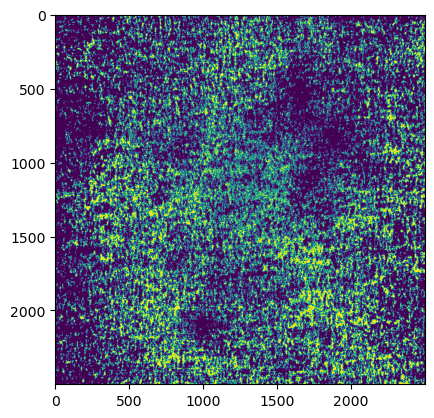

In [199]:
texture_mask = img.sum(-1) < 1.8
plt.imshow(texture_mask)

In [63]:
# plt.imshow(skimage.transform.rotate(mask, 45, resize=False, mode='reflect'))

In [65]:
def optimal_mask(mask, n=20):
    cr1, cr2 = mask.shape[0] // 4, mask.shape[0] - mask.shape[0] // 4
    cc1, cc2 = mask.shape[1] // 4, mask.shape[1] - mask.shape[1] // 4
    new = None
    current = 1.
    for i in range(n):
        m2 = skimage.transform.rotate(
            mask,
            np.random.randint(45, 315),
            center=(np.random.randint(cr1, cr2), np.random.randint(cc1, cc2)),
            resize=False, mode='reflect')
        frac = np.count_nonzero(mask == m2) / mask.size
    
        if frac < current:
            current = frac
            new = m2

    return new

In [121]:
m2 = optimal_mask(mask)
m3 = optimal_mask(mask & m2)

In [122]:
class Layer(object):
    def __init__(self, mask, color):
        self.mask = mask
        self.color = color

    def show(self):
        tile = np.full((self.mask.shape[0], self.mask.shape[1], 3), 255, dtype=np.uint8)
        tile[self.mask] = self.color
        plt.imshow(tile)
        plt.axis('off')
        plt.show()

In [234]:
def print_layer(layers, new):
    assert len(layers)
    output_layers = []

    fresh = new.mask.copy()
    for layer in layers:
        m = layer.mask & new.mask
        rgb_mix = mixbox.lerp(layer.color, new.color, .5)
        g1, g2 = [skimage.color.rgb2gray(np.asarray(x) / 255) for x in [layer.color, new.color]]
        delta = abs(g1 - g2)

        rgb_mix = mixbox.lerp(rgb_mix, (0, 0, 0), min(delta / 2 + .2, 1.))

        # show_colors([layer.color, new.color, rgb_mix])
        
        output_layers.append(Layer(m, rgb_mix))
        output_layers.append(Layer(layer.mask & ~new.mask, layer.color))

        fresh = fresh & ~layer.mask

    if np.count_nonzero(fresh):
        output_layers.append(Layer(fresh, new.color))

    return output_layers

def print_layers(layers):
    output_layers = []
    for i in range(len(layers)):
        if i == len(layers) - 1:
            break

        l1, l2 = layers[i:i + 2]
        if i == 0:
            output_layers = print_layer([l1], l2)

        else:
            output_layers = print_layer(output_layers, l2)
    return output_layers

In [170]:
def render_layers(layers):
    h, w = layers[0].mask.shape
    rgb = np.full((h, w, 3), 255, dtype=np.uint8)
    for l in layers:
        rgb[l.mask] = l.color
    return rgb

In [171]:
def show_colors(colors):
    blank = np.zeros((50, 50, 3), dtype=np.uint8)
    tiles = []
    for x in colors:
        tile = blank.copy()
        tile[...] = x
        tiles.append(tile)
    plt.imshow(np.concat(tiles, axis=1))
    plt.axis('off')
    plt.show()

In [258]:
max_prints = 20
for label, data in label_to_data.items():
    data['n_prints'] = int(max_prints * (1 - data['value']))
    print(data['n_prints'])


5
0
4
5
4
1
7
1
8
7
1
7
12


In [259]:
final_print = max([x['n_prints'] for x in label_to_data.values()])
final_print

12

In [297]:
color_pool = [
    (124, 207, 149),
    (115, 208, 209),
    (235, 145, 218),
    (160, 130, 224),
    # (255, 242, 145),
]
import random

In [298]:
shrunk = skimage.transform.rescale(labeled, .5, preserve_range=True, anti_aliasing=False, order=0)
shrunk.shape, texture_mask.shape

((2388, 1668), (2500, 2500))

In [299]:
layers = []
for i in range(final_print):
    print(i)
    optimal = optimal_mask(texture_mask, n=1)
    optimal = optimal[:shrunk.shape[0], :shrunk.shape[1]]
    overlay = np.zeros_like(optimal)
    for label, data in label_to_data.items():
        if data['n_prints'] > i:
            overlay |= shrunk == label
            
    mask = optimal & overlay
    color = random.choice(color_pool)
    layer = Layer(mask, color)
    # layer.show()
    
    layers.append(layer)

0
1
2
3
4
5
6
7
8
9
10
11


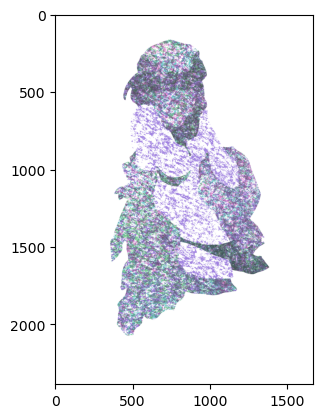

In [263]:
output_layers = print_layers(layers)
rgb = render_layers(output_layers)
plt.imshow(rgb)

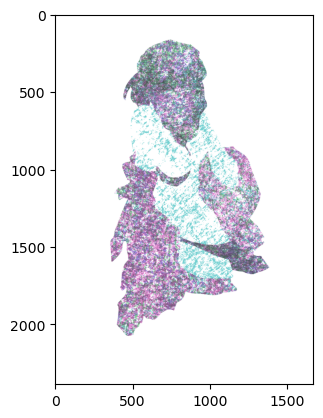

In [300]:
output_layers = print_layers(layers)
rgb = render_layers(output_layers)
plt.imshow(rgb)

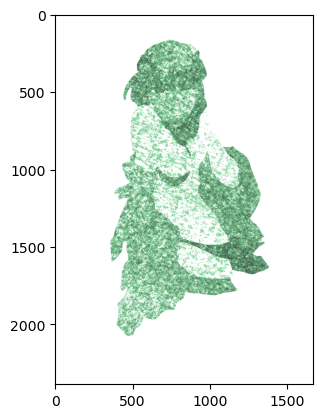

In [292]:
output_layers = print_layers(layers)
rgb = render_layers(output_layers)
plt.imshow(rgb)

In [190]:
data = next(iter(label_to_data.values()))
data.keys()

dict_keys(['direction', 'fill_types', 'centroid', 'prop', 'value'])

In [287]:
labeled_pts = skimage.morphology.label(pt_outlines)
props = skimage.measure.regionprops(labeled_pts)
len(props)

145

In [288]:
tol = .05
line_img = np.zeros_like(simple)
labeled_lines = np.zeros_like(labeled_pts)
for prop in props:
    r, c = prop.coords[0]
    val = values[r, c]

    min_val = val - tol
    max_val = val + tol
    val_mask = ((values >= min_val) & (values <= max_val))

    mask = skimage.morphology.flood(values, (r, c), tolerance=tol)

    # for i in range(4):
    #     mask = skimage.morphology.binary_erosion(mask)

    
    labeled_lines[mask] = prop.label

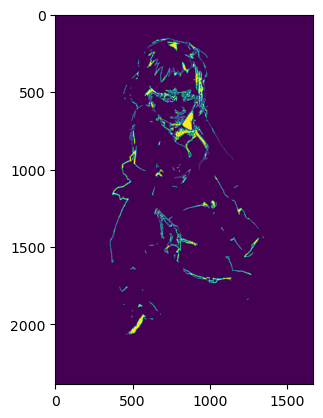

In [289]:
labeled_lines = skimage.transform.resize(labeled_lines, shrunk.shape, preserve_range=True, anti_aliasing=False, order=0)
plt.imshow(labeled_lines > 0)

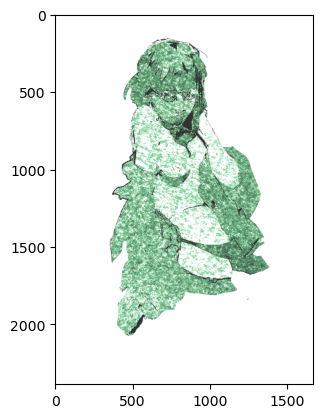

In [293]:
new = rgb.copy()
new[labeled_lines > 0] = [50, 50, 50]
plt.imshow(new)

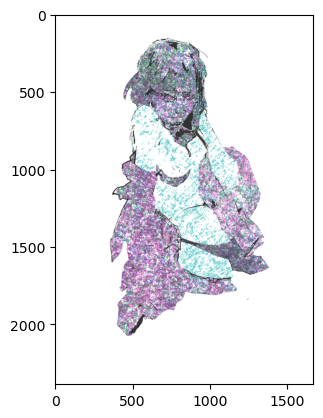

In [301]:
new = rgb.copy()
new[labeled_lines > 0] = [50, 50, 50]
plt.imshow(new)

In [275]:
rgb.shape, labeled_lines.shape

((2388, 1668, 3), (4776, 3336))

In [172]:
l1, l2, l3 = Layer(mask, (124, 207, 149)), Layer(m2, (115, 208, 209)), Layer(m3, (235, 145, 218))

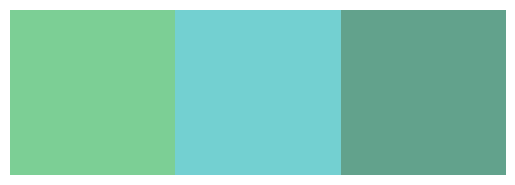

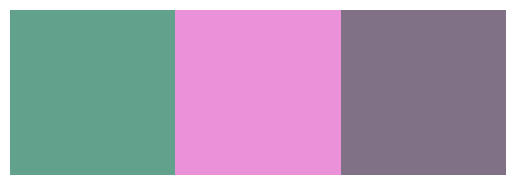

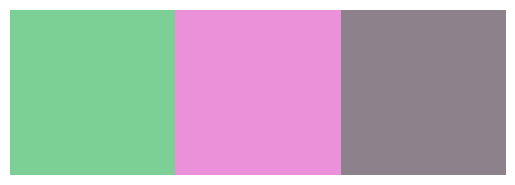

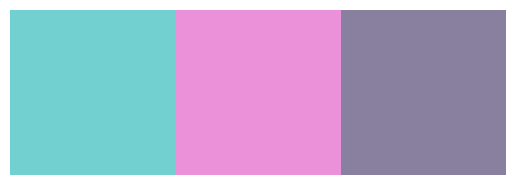

In [173]:
output_layers = print_layers([l1, l2, l3])

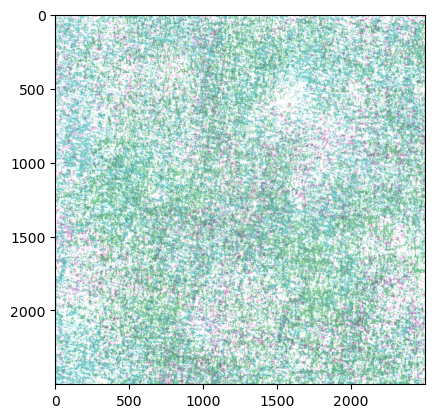

In [174]:
plt.imshow(render_layers(output_layers))

(np.float64(-0.5), np.float64(149.5), np.float64(49.5), np.float64(-0.5))

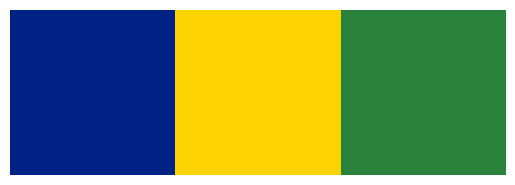

In [15]:
import mixbox

rgb1 = (0, 33, 133)  # blue
rgb2 = (252, 211, 0) # yellow
t = 0.5              # mixing ratio

rgb_mix = mixbox.lerp(rgb1, rgb2, t)

blank = np.zeros((50, 50, 3), dtype=np.uint8)
tiles = []
for x in [rgb1, rgb2, rgb_mix]:
    tile = blank.copy()
    tile[...] = x
    tiles.append(tile)
plt.imshow(np.concat(tiles, axis=1))
plt.axis('off')

In [134]:
skimage.color.rgb2gray(np.asarray(rgb1) / 255)

np.float64(0.7261988235294118)

(np.float64(-0.5), np.float64(149.5), np.float64(49.5), np.float64(-0.5))

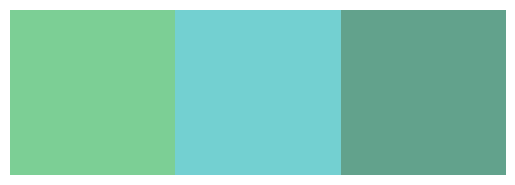

In [167]:
import mixbox

rgb1 = (124, 207, 149)
rgb2 = (115, 208, 209)
t = 0.5              # mixing ratio

rgb_mix = mixbox.lerp(rgb1, rgb2, t)

grays = [skimage.color.rgb2gray(np.asarray(x) / 255) for x in [rgb1, rgb2, rgb_mix]]
darkest = min(grays)
delta = abs(grays[0] - grays[1])

rgb_mix = mixbox.lerp(rgb_mix, (0, 0, 0), (delta / 2) + .2)

blank = np.zeros((50, 50, 3), dtype=np.uint8)
tiles = []
for x in [rgb1, rgb2, rgb_mix]:
    tile = blank.copy()
    tile[...] = x
    tiles.append(tile)
plt.imshow(np.concat(tiles, axis=1))
plt.axis('off')

(np.float64(-0.5), np.float64(149.5), np.float64(49.5), np.float64(-0.5))

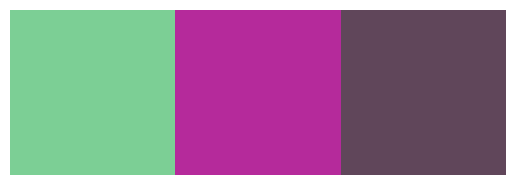

In [168]:
import mixbox

rgb1 = (124, 207, 149)
rgb2 = (181, 42, 155)
t = 0.5              # mixing ratio

rgb_mix = mixbox.lerp(rgb1, rgb2, t)

grays = [skimage.color.rgb2gray(np.asarray(x) / 255) for x in [rgb1, rgb2, rgb_mix]]
darkest = min(grays)
delta = abs(grays[0] - grays[1])

rgb_mix = mixbox.lerp(rgb_mix, (0, 0, 0), (delta / 2) + .2)

blank = np.zeros((50, 50, 3), dtype=np.uint8)
tiles = []
for x in [rgb1, rgb2, rgb_mix]:
    tile = blank.copy()
    tile[...] = x
    tiles.append(tile)
plt.imshow(np.concat(tiles, axis=1))
plt.axis('off')

In [138]:
grays

[np.float64(0.7261988235294118),
 np.float64(0.3124894117647059),
 np.float64(0.4837984313725491)]

In [1]:
import mixbox

In [71]:
!ls /Users/erikstorrs/miniconda3/envs/art/lib/python3.12/site-packages/mixbox

__init__.py      dates.py         namespaces.py    version.py
__pycache__      entities.py      parser.py        xml.py
binding_utils.py exceptions.py    signals.py
compat.py        fields.py        typedlist.py
datautils.py     idgen.py         vendor


In [72]:
!pip install pymixbox

In [74]:
!pip uninstall mixbox

Found existing installation: mixbox 1.0.5
Uninstalling mixbox-1.0.5:
  Would remove:
    /Users/erikstorrs/miniconda3/envs/art/lib/python3.12/site-packages/mixbox-1.0.5.dist-info/*
    /Users/erikstorrs/miniconda3/envs/art/lib/python3.12/site-packages/mixbox/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [76]:
mixbox.lerp

/Users/erikstorrs/miniconda3/condabin/conda
